# Importing ressources

In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# sklearn part
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# other models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# others
from scipy.stats import uniform, randint

In [2]:
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

df_new_bs_features_train = pd.read_csv('data/new_bs_features_train.csv')
df_new_bs_features_test = pd.read_csv('data/new_bs_features_test.csv')

In [3]:
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [4]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

**FIXING SEED**

In [5]:
SEED = 42

# Pipeline

### Notes :
- Features plaace hierarchy lv1/lv2 not useful
- grunnkret ID important
- robust scaler not useful here
- encoding on the df_all is better than indivudal (fit + transform)
- scaling the data with the fit of just train is better to prevent leak (fit + transform) 
- Need to clean the pipeline

In [6]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [7]:
def create_population_age():
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
#     df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
#     df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
#     df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
    return df_grunnkrets_population

In [8]:
def create_population_repartition():
    return df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_6_to_17_years', 'couple_children_18_or_above', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_6_to_17_years', 'single_parent_children_18_or_above', 'singles']]

In [9]:
def create_income_repartition():
    return df_grunnkrets_income_house[['grunnkrets_id', 'all_households']]

In [10]:
def create_grunnkret_geodata():
    return df_grunnkrets_stripped[['grunnkrets_id', 'area_km2', 'municipality_name']]

In [11]:
def create_hierarchy():
    return df_plaace_hierarchy[['plaace_hierarchy_id', 'lv3_desc']]

In [12]:
def fix_municipalities(current_df):
    # Get the rows with missing municipality
    df_missing_mun = current_df[current_df["municipality_name"].isna()]
    # Create a copy of the current df and drop row where mun = NaN + Reset index
    current_df_copy = current_df.copy().dropna(subset=['municipality_name'])
    current_df_copy = current_df_copy.reset_index(drop=True)
    # For each missing municipality
    for index, row in df_missing_mun.iterrows():
        # Create a df with the the difference with the loc of the current store and all the others stores
        tmp_df = pd.concat([current_df_copy.loc[:, ["lat"]] - row.lat, current_df_copy.loc[:, ["lon"]] - row.lon], axis=1)
        # Find the idx of the one with the smallest error (the closest from the other)
        idx = np.argmin(np.linalg.norm(tmp_df.to_numpy(), axis=1))
        # Retrieve the municipality of the closest one and input it in the missing one
        current_df.loc[index, "municipality_name"] = current_df_copy.loc[idx, "municipality_name"]
    return current_df

In [18]:
# store_id_splitted = 
tmp = pd.DataFrame([i.split('-') for i in df_train['store_id']], columns=['str1', 'str2', 'str3', 'none'])

# store_id_splitted = store_id_splitted.drop('none', axis=1)
# store_id_splitted[store_id_splitted['str1'] == ''] = '1'
# store_id_splitted[store_id_splitted['str2'] == ''] = '1'
# store_id_splitted[store_id_splitted['str3'] == ''] = '1'

# store_id_splitted['str1'] = store_id_splitted['str1'].astype('int')
# store_id_splitted['str2'] = store_id_splitted['str2'].astype('int')
# store_id_splitted['str3'] = store_id_splitted['str3'].astype('int')

,str1,str2,str3,none
0,983540538,974187930,44774,None
1,987074191,973117734,44755,None
2,984890265,981157303,64491,None
3,914057442,992924179,126912,None
4,913018583,913063538,668469,None
...,...,...,...,...
12854,915789943,915806929,781991,None
12855,917921733,917982368,868081,None
12856,911721961,911764474,496764,None
12857,914337046,914343372,721294,None


In [174]:
# Removing outliers
df_train = df_train.drop(df_train[df_train.revenue <= df_train.revenue.quantile(.03)].index)
df_train = df_train.drop(df_train[df_train.revenue >= df_train.revenue.quantile(1-.04)].index)

X_train = df_train.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]
X_test = df_test.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]

X_train['lat'] = X_train.lat * 11.112
X_train['lon'] = X_train.lon * 6.4757
X_test['lat'] = X_test.lat * 11.112
X_test['lon'] = X_test.lon * 6.4757

# Area & Municipality
X_train = pd.merge(X_train, create_grunnkret_geodata(), how="left", on="grunnkrets_id")
X_test = pd.merge(X_test, create_grunnkret_geodata(), how="left", on="grunnkrets_id")

# Plaace Hierarchy
X_train = pd.merge(X_train, create_hierarchy(), how='left', on='plaace_hierarchy_id')
X_test = pd.merge(X_test, create_hierarchy(), how='left', on='plaace_hierarchy_id')

# Population
X_train = pd.merge(X_train, create_population_age(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_age(), how='left', on='grunnkrets_id')
# Population density
X_train["population_density"] = X_train["total_population"] / X_train["area_km2"]
X_test["population_density"] = X_test["total_population"] / X_test["area_km2"]

# Income
X_train = pd.merge(X_train, create_income_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_income_repartition(), how='left', on='grunnkrets_id')

# Distance (shop-closest BS & mean BS in 1km radius)
# X_train = pd.merge(X_train, df_new_bs_features_train, how='left', on='store_id')
# X_test = pd.merge(X_test, df_new_bs_features_test, how='left', on='store_id')
# X_train = X_train.drop(['BS_closest_standard_holdeplass', 'BS_mean_1km_lokalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_annen_viktig_holdeplass'],axis=1)
# X_test = X_test.drop(['BS_closest_standard_holdeplass', 'BS_mean_1km_lokalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_annen_viktig_holdeplass'],axis=1)

""" ENCODING """
# Sales Channel Name
le = label_uniformier(X_train['sales_channel_name'], X_test['sales_channel_name'])
X_train['encoded_channel_name'] = le.transform(X_train['sales_channel_name'])
X_test['encoded_channel_name'] = le.transform(X_test['sales_channel_name'])

# Mall Name
X_train['mall_name'] = X_train['mall_name'].fillna('0')
X_test['mall_name'] = X_test['mall_name'].fillna('0')
le = label_uniformier(X_train['mall_name'], X_test['mall_name'])
X_train['encoded_mall'] = le.transform(X_train['mall_name'])
X_test['encoded_mall'] = le.transform(X_test['mall_name'])

# Chain Name
X_train['chain_name'] = X_train['chain_name'].fillna('0')
X_test['chain_name'] = X_test['chain_name'].fillna('0')
le = label_uniformier(X_train['chain_name'], X_test['chain_name'])
X_train['encoded_chain'] = le.transform(X_train['chain_name'])
X_test['encoded_chain'] = le.transform(X_test['chain_name'])

# Hierarchy LV3
le = label_uniformier(df_plaace_hierarchy['lv3_desc'], df_plaace_hierarchy['lv3_desc'])
X_train['encoded_lv3'] = le.transform(X_train['lv3_desc'])
X_test['encoded_lv3'] = le.transform(X_test['lv3_desc'])

# Municipality feature
X_train = fix_municipalities(X_train)
X_test = fix_municipalities(X_test)
le = label_uniformier(X_train['municipality_name'], X_test['municipality_name'])
X_train['municipality_encoded'] = le.transform(X_train['municipality_name'])
X_test['municipality_encoded'] = le.transform(X_test['municipality_name'])

""" DROP USELESS """
X_train = X_train.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)
X_test = X_test.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)

""" FILLING NAN WITH MEAN """
X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

""" SCALING """
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = np.log10(Y_train + 1)
Y_train = scaler.fit_transform(Y_train)

In [175]:
X_train

,grunnkrets_id,population_density,all_households,encoded_channel_name,encoded_mall,encoded_chain,encoded_lv3,municipality_encoded
0,-0.578890,-2.508693e-01,-0.761195,-0.371802,2.087915,1.768674,-0.442807,-1.410094
1,-1.098237,-4.499875e-17,-1.026875,-0.371802,-0.378061,1.768674,-0.442807,0.324184
2,-0.573748,-1.213683e-01,-1.325905,-0.371802,1.770264,0.072189,-0.442807,0.460876
3,1.495016,1.419349e-01,-0.813442,-0.371802,1.168398,0.072189,-0.442807,-1.512613
4,1.146020,-4.499875e-17,1.739980,-0.371802,3.559142,0.072189,-0.442807,1.238310
...,...,...,...,...,...,...,...,...
11969,-1.212131,-8.883347e-02,0.309308,-1.778153,-0.378061,-0.508187,-2.399729,1.332286
11970,-0.751413,1.077281e-02,-1.947308,-1.778153,0.599970,1.054364,-2.399729,-0.965846
11971,-1.218930,5.416840e-01,-0.299867,-1.778153,3.400316,1.054364,-2.399729,0.734259
11972,0.283781,4.442789e-01,-0.942391,-1.778153,0.524737,-0.508187,-2.399729,0.623197


**Warning**

Only run this for testing part, not for the submission model training

In [91]:
X_train, X_train_test, Y_train, Y_train_test = train_test_split(X_train, Y_train)

# Individual models

In [64]:
model = RandomForestRegressor(
    n_estimators=180,
    criterion='absolute_error',
    max_depth=None,
    min_samples_split=14,
    min_samples_leaf=11,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=SEED,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

In [120]:
model = DecisionTreeRegressor(
    criterion = 'absolute_error',
    splitter = 'random',
    max_depth = None,
    min_samples_split=75,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    min_impurity_decrease=0.0,
    max_features=None,
    max_leaf_nodes=None,
    random_state=SEED
)

In [127]:
model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=300, 
    random_state=SEED,
    colsample_bytree=0.8958238323555624, 
    gamma=0.11909139052336326,
    learning_rate=0.05983241782780355,
    subsample=0.8889067727422637,
    max_depth=5,
)

In [93]:
model = LGBMRegressor(
    num_leaves=70,
    max_depth=7, 
    n_estimators=2000,
    min_data_in_leaf = 400,
    learning_rate=0.05,
    random_state=SEED,
)

In [14]:
model = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.005,
    loss='square',
    random_state=SEED,
)

In [25]:
model = GradientBoostingRegressor(
    learning_rate=0.064312,
    n_estimators=1000,
    subsample=1.0, 
    criterion='squared_error', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=20,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
    random_state=SEED, 
)

In [110]:
model = CatBoostRegressor(
    learning_rate=0.04,
    iterations=100,
    depth=8,
    random_seed=SEED,
    silent=True,
)

In [111]:
fitted_model = model.fit(X_train, np.ravel(Y_train))

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


**Warning**

Could only be run on testing part, not during full submission

### Testing part

In [53]:
# Prediction on the data train testing part (only if splitted then)
Y_Pred_train = model.predict(X_train_test)

### Submission part

In [54]:
# Prediction on the data test
Y_Pred = model.predict(X_test)

# Ensemble models

In [176]:
rf_model = RandomForestRegressor(
    n_estimators=180,
    criterion='absolute_error',
    max_depth=None,
    min_samples_split=14,
    min_samples_leaf=11,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=SEED,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

lgbm_model = LGBMRegressor(
    boosting_type='gbdt',
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=8,
    metric='auc',
    min_data_in_leaf=10,
    min_split_gain=0.01,
    num_leaves=200,
    objective='binary',
    subsample=0.5,
)

# cb_model = CatBoostRegressor(
#     learning_rate=0.04,
#     iterations=100,
#     depth=8,
#     random_seed=SEED,
#     silent=True,
# )

xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000, 
    random_state=SEED,
    colsample_bytree=0.8958238323555624, 
    gamma=0.11909139052336326,
    learning_rate=0.05983241782780355,
    subsample=0.8889067727422637,
    max_depth=6,
)

gb_model = GradientBoostingRegressor(
    subsample= 0.75,
    n_estimators=2000,
    max_depth=4,
    learning_rate=0.01,
    random_state=SEED,
)


In [177]:
# Uncomment or Comment in function of the model used
models = [
    rf_model,
    lgbm_model,
#     cb_model,
    xgb_model,
#     gb_model,
]

for model in models:
    model.fit(X_train, np.ravel(Y_train))

## Basic Mean Ensemble Model

### Testing part

In [129]:
predictions = []
for model in models:
    predictions.append(model.predict(X_train_test))

Y_Pred_train = np.mean(predictions, axis=0)

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


### Submission part

In [178]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))
    
Y_Pred = np.mean(predictions, axis=0)

### Testing part

In [105]:
Y_Pred_train = META_MODEL.predict(x_test)

### Submission part

In [282]:
Y_Pred = META_MODEL.predict(x_test)

# VC

In [ ]:
votingR = VotingRegressor(estimators=[('lgb', lgbBest), ('gradientboostBest', gradientboostBest),
('xgbrbest', xgbrbest)], n_jobs=4)

votingR = votingR.fit(X_train, np.ravel(Y_train))
avg_prediction=votingR.predict(X_test)

# Evaluation

Get the RMSLE of the current prediction

In [55]:
print(f'RMSLE prediction: {rmsle(10 ** scaler.inverse_transform(Y_train_test) - 1, 10 ** scaler.inverse_transform([[elmt] for elmt in Y_Pred_train]) - 1):.4f}')

RMSLE prediction: 0.7554


Plot the graph with the prediction and the real value

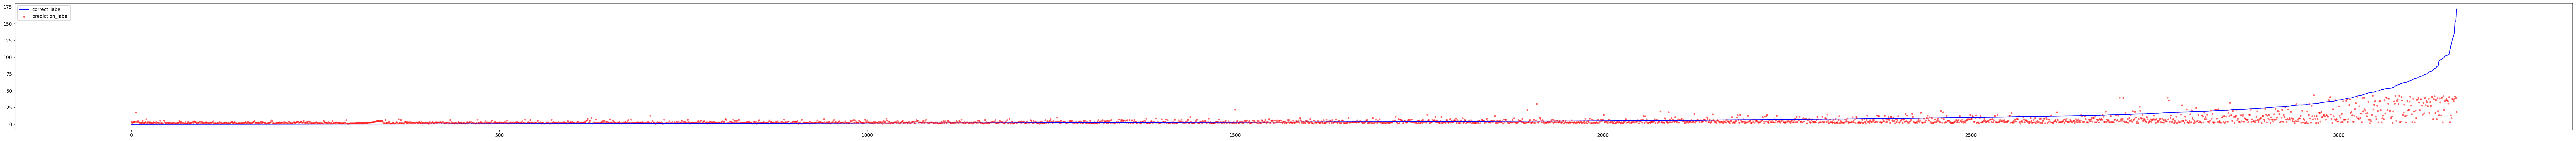

In [56]:
plt.figure(figsize=(100, 5), dpi=150)
tmp1, tmp2 = zip(*sorted(zip(10 ** scaler.inverse_transform(Y_train_test) - 1, 10 ** scaler.inverse_transform([[elmt] for elmt in Y_Pred_train]) - 1)))
plt.plot(range(len(Y_Pred_train)),  tmp1, 'b', label='correct_label', )
plt.scatter(range(len(Y_Pred_train)),  tmp2, label='prediction_label', color='r', marker='.', alpha=0.5)
plt.legend(loc="upper left")

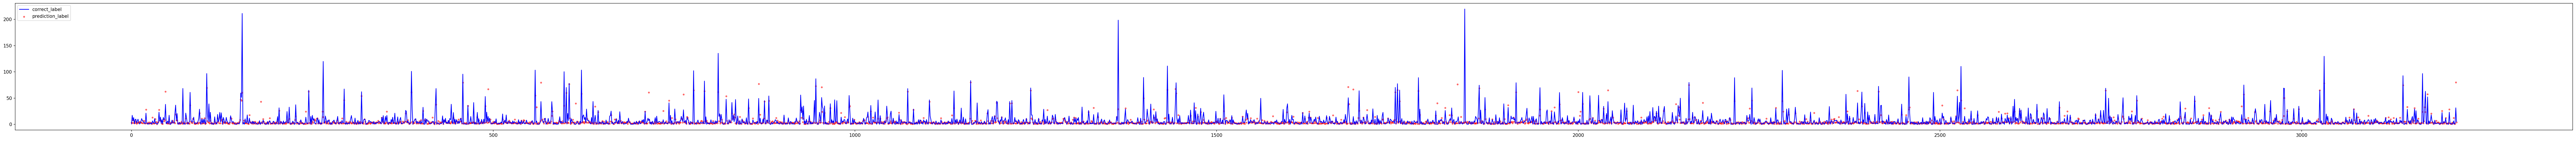

In [152]:
plt.figure(figsize=(100, 5), dpi=150)
plt.plot(range(len(Y_Pred_train)),  10 ** scaler.inverse_transform(Y_train_test) - 1, 'b', label='correct_label', )
plt.scatter(range(len(Y_Pred_train)),  10 ** scaler.inverse_transform([[elmt] for elmt in Y_Pred_train]) - 1, label='prediction_label', color='r', marker='.', alpha=0.5)
plt.legend(loc="upper left")

In [245]:
cv = KFold(5)
score = []
for n, (idx_train, idx_test) in enumerate(cv.split(X_train)):
    # Uncomment or Comment in function of the model used
    models = [
        RandomForestRegressor(
            n_estimators=180,
            criterion='absolute_error',
            max_depth=None,
            min_samples_split=14,
            min_samples_leaf=11,
            min_weight_fraction_leaf=0.0,
            max_features=None,
            max_leaf_nodes=300,
            min_impurity_decrease=0.0,
            bootstrap=True,
            oob_score=False,
            n_jobs=None,
            random_state=SEED,
            verbose=0,
            warm_start=False,
            ccp_alpha=0.0,
            max_samples=None
        ),

        LGBMRegressor(
            num_leaves=70,
            max_depth=7, 
            random_state=SEED,  
            n_estimators=2000,
            min_data_in_leaf = 400,
            learning_rate=0.05,
        ),

        cb_model = CatBoostRegressor(
            learning_rate=0.04,
            iterations=100,
            depth=8
            random_seed=SEED,
            silent=True,
        ),

        XGBRegressor(
            objective='reg:squarederror', 
            n_estimators=300, 
            random_state=SEED,
            colsample_bytree=0.8958238323555624, 
            gamma=0.11909139052336326,
            learning_rate=0.05983241782780355,
            subsample=0.8889067727422637,
            max_depth=5,
        )
    ]
    
    
    X_train_train, X_train_test = X_train.iloc[idx_train, :], X_train.iloc[idx_test, :]
    Y_train_train, Y_train_test = Y_train[idx_train], Y_train[idx_test]

    for model in models:
        model.fit(X_train_train, np.ravel(Y_train_train))
    
    predictions = []
    for model in models:
        predictions.append(model.predict(X_train_test))
    Y_Pred_train = np.mean(predictions, axis=0)
    
    score.append(rmsle(scaler.inverse_transform(Y_train_test),scaler.inverse_transform([[elmt] for elmt in Y_Pred_train])))
    print(f'Fold {n} - RMSLE prediction: {rmsle(scaler.inverse_transform(Y_train_test),scaler.inverse_transform([[elmt] for elmt in Y_Pred_train])):.4f}')

np.mean(score)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Fold 0 - RMSLE prediction: 0.2231
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Fold 1 - RMSLE prediction: 0.2274
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Fold 2 - RMSLE prediction: 0.2300
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Fold 3 - RMSLE prediction: 0.1876
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Fold 4 - RMSLE prediction: 0.2330


0.22022856201554886

# Submission

**Warning**

When submitting, don't split the data : Train the model on the full data_train

In [179]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
# First apply the reverse scaler then the log function
submission['predicted'] = np.asarray(10 ** scaler.inverse_transform([[elmt] for elmt in Y_Pred]) - 1)
# Switch for Linear Model (when already 2D array)
# submission['predicted'] = np.asarray(10 ** scaler.inverse_transform(Y_Pred) - 1)


# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission.csv', index=False)
submission.head()

,id,predicted
0,914206820-914239427-717245,3.548234
1,916789157-916823770-824309,7.079817
2,913341082-977479363-2948,5.630222
3,889682582-889697172-28720,5.495262
4,997991699-998006945-417222,8.126453


# Hyperparameters set up

In [33]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            

params = {'depth': [4,5,6,7,8,9, 10],
          'learning_rate': [0.01,0.02,0.03,0.04],
          'iterations': [10, 20,30,40,50,60,70,80,90, 100]
}


model = CatBoostRegressor(
    random_state=SEED,
    silent=True,
)

search = RandomizedSearchCV(
                        model,
                        param_distributions=params,
                        scoring="neg_mean_absolute_error",
                        random_state=42,
                        n_iter=200, 
                        cv=3,
                        verbose=1,
                        n_jobs=1,
                        return_train_score=True
                    )

search.fit(X_train, np.ravel(Y_train))
report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\thepy\AppData\Local\Programs\Python\Python3

Model with rank: 1
Mean validation score: -0.591 (std: 0.002)
Parameters: {'learning_rate': 0.04, 'iterations': 100, 'depth': 8}



In [ ]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=SEED)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_train):
    X_train, X_test = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_train, y_test = Y_train[train_ix], Y_train[test_ix]

    cv_inner = KFold(n_splits=3, shuffle=True, random_state=SEED)

    model = CatBoostRegressor(
        random_state=SEED,
        silent=True,
    )
    params = {'depth': [4,5,6,7,8,9, 10],
              'learning_rate': [0.01,0.02,0.03,0.04],
              'iterations': [10, 20,30,40,50,60,70,80,90, 100]
    }
    
    search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)

    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

# Notes

After some testing with crossfold validation, here are the results :
- RF model | + bus stops features (+ 1km mean, + 500m count, + closest distance) + lat + lon : 
        0.2273918735290839
- RF model | + bus stops features (+ 1km mean, + 500m count, + closest distance) - lat - lon : 
        0.2274120365912414
- RF model | - bus stops features (+ 1km mean, + 500m count, + closest distance) - lat - lon : 
        0.22666878490992676
- RF model | + bus stops features (- 1km mean, - 500m count, + closest distance) - lat - lon : 
        0.22765354157047207
- Ensemble model (mean) [XGB,LGBM, RF] | + bus stops features (+ 1km mean, - 500m count, + closest distance) - lat - lon : 
        0.22022856201554886




## Meta Models

In [265]:
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

# oof = out of fold
def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index, :]
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index, :]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Testing part

In [79]:
rf_oof_train, rfr_oof_test = get_oof(rf_model, X_train, np.ravel(Y_train), X_train_test)
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_model, X_train, np.ravel(Y_train), X_train_test)
cb_oof_train, cb_oof_test = get_oof(cb_model, X_train, np.ravel(Y_train), X_train_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_model, X_train, np.ravel(Y_train), X_train_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


### Submission part

In [266]:
rf_oof_train, rf_oof_test = get_oof(rf_model, X_train, np.ravel(Y_train), X_test)
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_model, X_train, np.ravel(Y_train), X_test)
# cb_oof_train, xgb_oof_test = get_oof(cb_model, X_train, np.ravel(Y_train), X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_model, X_train, np.ravel(Y_train), X_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


.

In [269]:
x_train = np.concatenate((
    rf_oof_train,
    lgbm_oof_train,
#     cb_oof_train,
    xgb_oof_train,
), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    lgbm_oof_test,
#     cb_oof_test,
    xgb_oof_test,
), axis=1)

In [270]:
# OOF predictions
meta_df = pd.DataFrame(x_train, columns=[
    'RF',
    'LGBM',
#     'CB',
    'XGB',
])
meta_df['label'] = Y_train
meta_df

,RF,LGBM,XGB,label
0,-0.042601,0.348767,0.372555,1.323375
1,0.258054,1.330714,1.485652,1.584523
2,-0.180905,0.363703,0.206270,1.220615
3,0.061516,0.462956,0.371533,0.725651
4,0.330382,0.650805,0.481446,0.118804
...,...,...,...,...
12854,-0.216457,-0.430716,-0.368927,-1.467263
12855,0.323317,0.400395,0.641174,-0.539348
12856,0.071494,0.031125,0.192239,2.030775
12857,-0.130869,-0.216780,-0.246785,-0.051641


In [280]:
META_MODEL = lgb.LGBMRegressor(
    max_depth=3, 
    random_state=SEED, 
    silent=True,
    metric='mse',
    n_jobs=-1, 
    n_estimators=1050,
    subsample=0.9,
    learning_rate=0.005
)

In [275]:
META_MODEL = LinearRegression()

In [271]:
META_MODEL = CatBoostRegressor(
    depth=3, 
    random_state=SEED, 
    silent=True,
    iterations=600,
    l2_leaf_reg=1,
    min_child_samples=2,
    learning_rate=0.025
)

In [281]:
META_MODEL.fit(x_train, Y_train)

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(learning_rate=0.005, max_depth=3, metric='mse', n_estimators=1050,
              random_state=42, silent=True, subsample=0.9)